# OSM COMPETITION: A Meta Model that optimally combines the outputs of other models.

The aim of the competition is to develop a computational model that predicts which molecules will block the malaria parasite's ion pump, PfATP4.

Submitted by James McCulloch - james.duncan.mcculloch@gmail.com

## Final Results. The DNN meta model combines probability maps of molecular structure and EC50 classifiers and has a predictive score of AUC = 0.89 on the test molecules. This model ("osm" in the software) is selected for the competition.

### Other "off-the-shelf" meta models from SKLearn have predictive scores of AUC [0.81, 0.85] (see below) and support the results obtained from the meta DNN. 


#### What is a Meta Model?

* Each predictive model based on fingerprints or another SMILE based description vector such as DRAGON brings a certain amount of predictive power to the task of assessing likely molecular activity against PfATP4.

* What the meta model does is combine the predictive power of each model in an optimal way to produce a more predictive composite model.

* It does this by taking as it's input the probability maps (the outputs) of other classifiers,

* The two models chosen as inputs to the meta model are:

    1. A Neural Network model that uses the DRAGON molecular descriptor to estimate molecular PfATP4 ion activity directly. This model had modest predictive power of AUC=0.77. See the first notebook for details. 
    
    2. A logistic classifier that uses the Morgan fingerprints (mol radius = 5) to predict the EC50 <= 500 nMol class. This model was discussed in notebook 2 and has a predictive power of AUC=0.93 for the test molecules. Crucially, this predictive power is for EC50 only, not PfATP4 ion activity. For the test set, EC50 and PfATP4 ion activity are closely correlated because these molecules have similar structures and were designed to be active against PfATP4. However, other molecules from the training set with different structures have different sites of activity and membership of the EC50 <= 500 nMol class is not predictive of PfATP4 ion activity.
    
    

#### Finding the Optimal Final Model.

A DNN and a variety SKlearn classifiers were trained as Meta Models against the probability maps of the 2 models described above and the resultant Area Under Curve (AUC) statistics against the test molecules are tabulated below. Note the meta model is a binary classifier [ACTIVE, INACTIVE] for ion activity it does not attempt to classify molecules as [PARTIAL].

### Results Summary

In [8]:
from IPython.display import display
import pandas as pd
print("Meta Results")
meta_results = pd.read_csv("./meta_results.csv")
display(meta_results)


Meta Results


,META MODEL,DNN,NBC,SVMC,LOGC
0,AUC,0.89,0.83,0.85,0.81


Where the META MODELs are as follows:


1. DNN - A Deep Neural Network classifier [16, 32, 32, 16, 2] from the Keras toolkit. Cross-entropy loss function.

2. NBC - A Naive Bayes Classifier

3. SVMC - A support vector machine classifier.

4. LOGC - A Logistic classifier.


### Modelling.

The Meta Models run on Linux and Windows under Python 2.7 and 3.5 (Mac untested):

1. Download (follow the readme setup) the entire directory tree from google drive here: https://github.com/kellerberrin/OSM-QSAR. Detailed instructions will be also posted so that the withheld molecules can be tested against the optimal model with minimum hassle. The pre-trained DRAGON classifier "ION_DRAGON_625.krs" must be in the model directories. In addition, for the "osm" model, the pre-trained meta model "ION_META_40.krs" should be in the "osm" model directory. The software should give sensible error messages if they are missing.  

2. Make sure you have setup and activated the python anaconda environment as described in "readme.md".


For the optimal OSM meta model (--help for flag descriptions) the following cmd was used (the clean flag is optional it removes previous results from the model directory):

```
$python OSM_QSAR.py --classify osm --load ION_META --epoch 40 --train 0 [--clean]
```

For the svmc SKLearn meta model (--help for flag descriptions) the following cmd was used (the clean flag is optional it removes previous results from the model directory):

```
$python OSM_QSAR.py --classify osm_sk [--clean]
```



##### We visualize the training set probability maps by normalizing them to the unit interval [0, 1] and sorting them in descending order. 

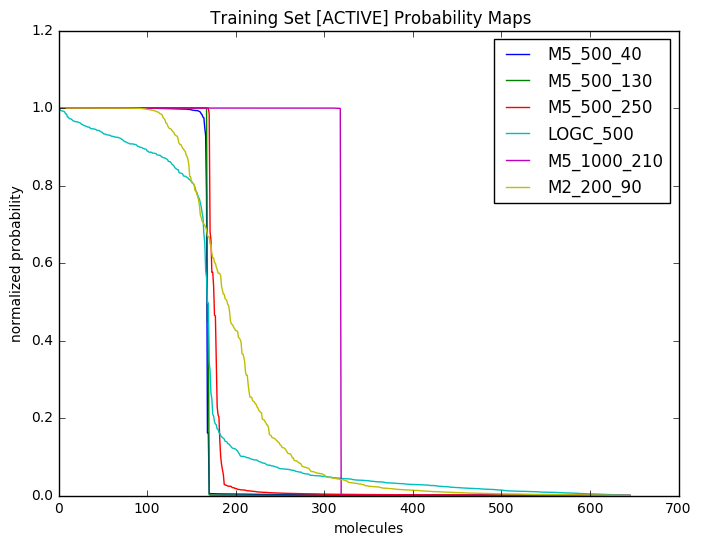

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from sklearn.preprocessing import minmax_scale

def sort_map(column):
    array = minmax_scale(train_results[column])
    return array[np.argsort(-array)]

scale = 1.0
fig = plt.figure(num=None, figsize=(8 * scale, 6 * scale), dpi=80, facecolor='w', edgecolor='k')
for map in all_active: plt.plot(sort_map(map), label=map)
xlabel("molecules")
ylabel("normalized probability")
title(" Training Set [ACTIVE] Probability Maps")
legend(loc=1); # upper right corner

In [6]:

def mol_label_list(data_frame):  # Function to produce rdkit mols and associated molecular labels
    id = data_frame["ID"].tolist()
    klass =  data_frame["ACTUAL_500"].tolist()
    potency = data_frame["EC50"].tolist()
    ion_activity = data_frame["ION_ACTIVITY"].tolist()
    map_prob = data_frame["M5_500_250"].tolist()
    labels = []
    for idx in range(len(id)):
        labels.append("{} {} {} {} {:5.0f} ({:5.4f})".format(idx+1, id[idx],
                                                           klass[idx][0], ion_activity[idx][0],
                                                           potency[idx]*1000, map_prob[idx]))
    smiles = data_frame["SMILE"].tolist()
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    return mols, labels


('len(ec50_200_active):', 71, 'len(ec50_500_active):', 169, 'len(ec50_500_added):', 98, 'len(ec50_1000_active):', 319, 'len(ec50_1000_added):', 150)


In [7]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
IPythonConsole.ipython_useSVG=True

####  ION_ACTIVITY [ACTIVE] in EC50_200

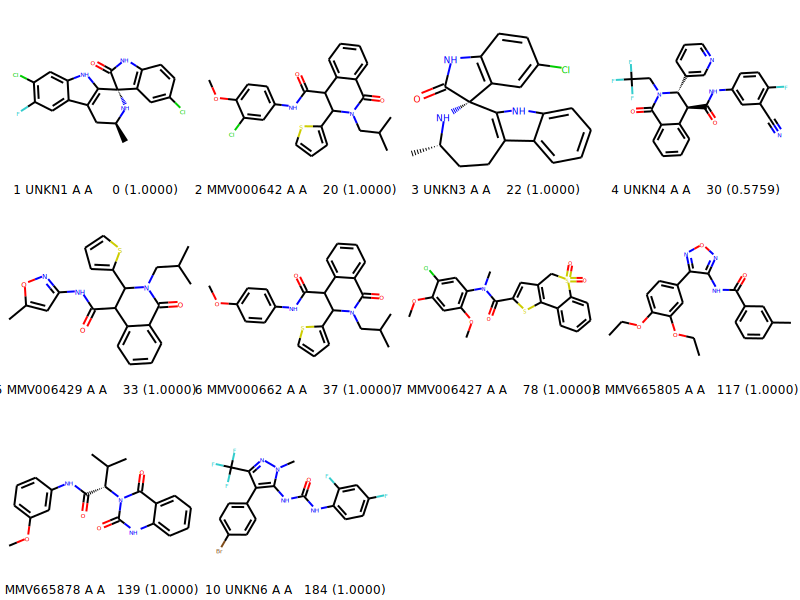

In [8]:
ion_active = ec50_200_active.loc[train_results["ION_ACTIVITY"] == "ACTIVE"].sort_values("EC50")
mols, labels = mol_label_list(ion_active)
Draw.MolsToGridImage(mols,legends=labels,molsPerRow=4)

####  ION_ACTIVITY [ACTIVE] Exemplar molecules that were added to the training set when moving from EC50_200 to EC50_500

#### Commentary

These molecules have the same Triazole arm as we noticed in the previous notebook when trying to classifiy the molecular ION_ACTIVITY using D840_ACTIVE (DRAGON). This structure is also well represented in the test molecules.

####  ION_ACTIVITY [ACTIVE] Exemplar molecules that were added to the training set when moving from EC50_500 to EC50_1000

####  The results of the EC50_500 classification of the test molecules.  

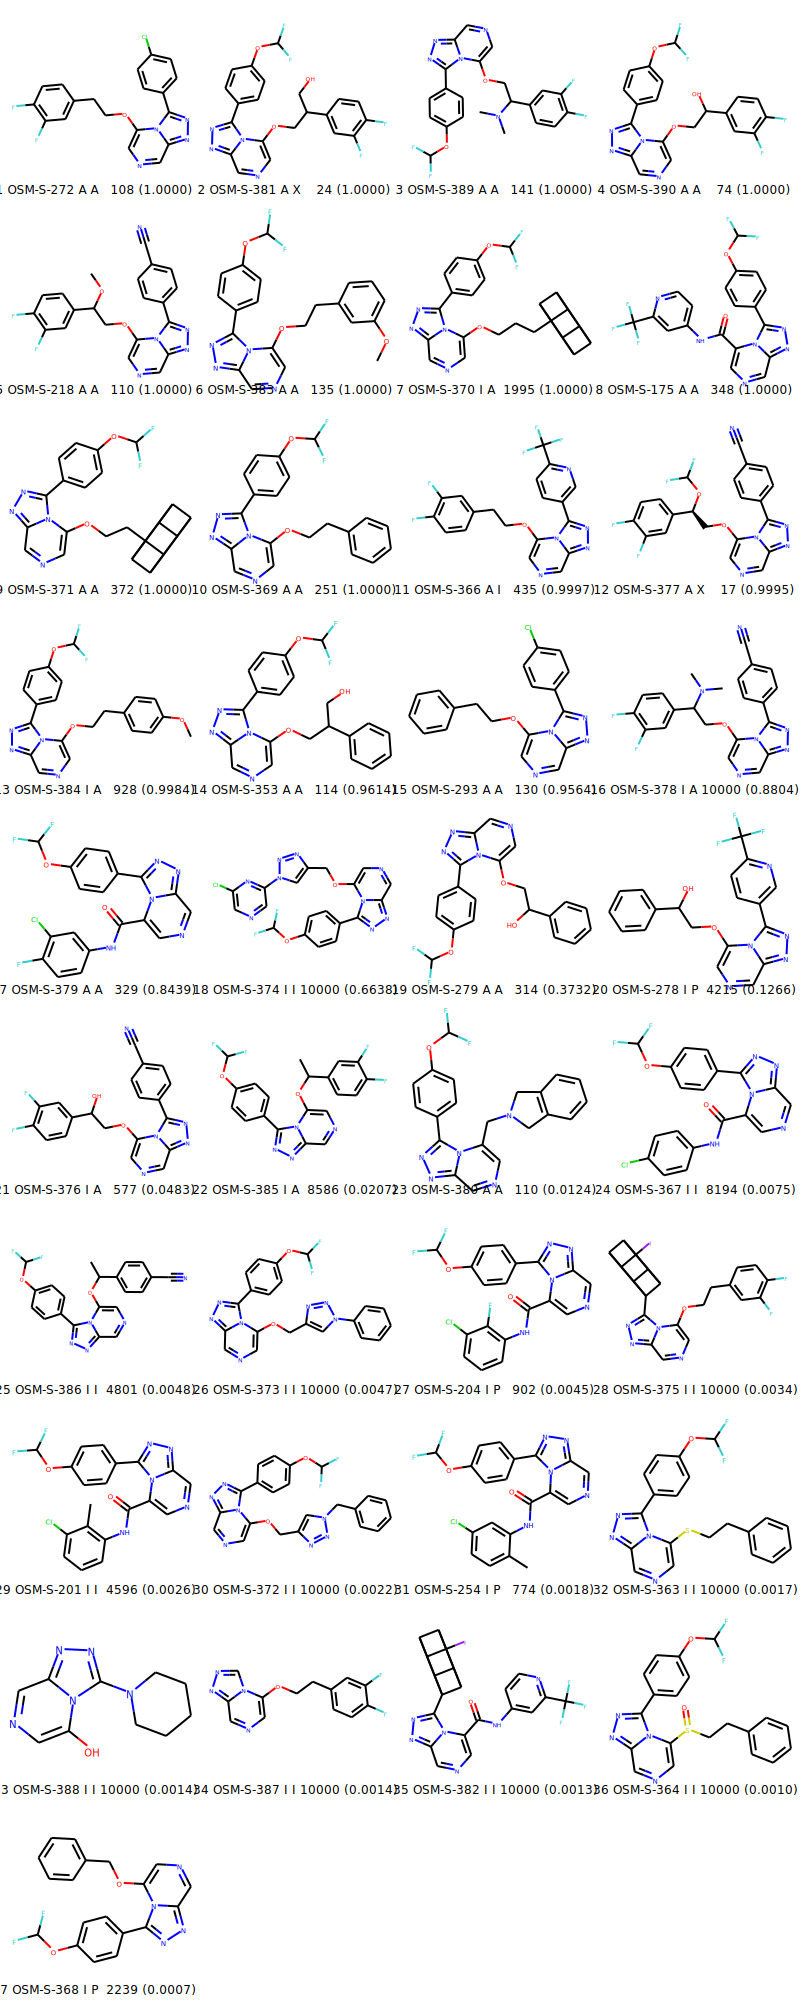

In [11]:
sorted = test_results.sort_values("M5_500_250", ascending=False)
mols, labels = mol_label_list(sorted)
Draw.MolsToGridImage(mols,legends=labels,molsPerRow=4)

#### Commentary

